In [7]:
# linear algebra
import math
import numpy as np

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F

# display
from torchview import draw_graph
from IPython.display import display
from IPython.core.display import SVG, HTML

# plot
import matplotlib.pyplot as plt
import matplotlib

# progress bar
from tqdm import tqdm

# functions
from functions import *

# support for automatic reloading
%load_ext autoreload
%autoreload 2

from models.monLoss import FCNet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### $f_6(x,y) = x^2 + y^2$: monotonic increasing in $x$ and $y$

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_6709/2578617900.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z6_tensor_2D = torch.tensor(f6(X_tensor_f6_2D, Y_tensor_f6_2D))
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_6709/2578617900.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z6_tensor = torch.tensor(Z6_tensor_2D.ravel()).float()


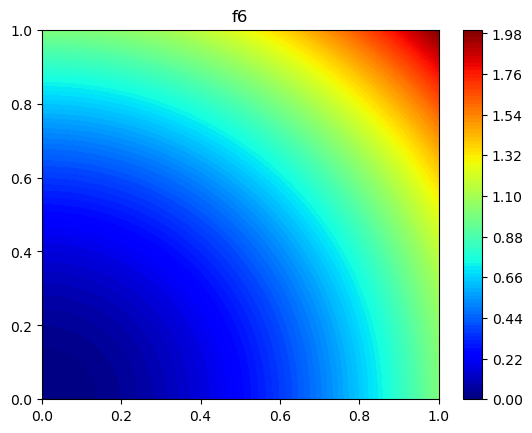

In [8]:
# define space
X_tensor_f6 = torch.linspace(0, 1, 100)
Y_tensor_f6 = torch.linspace(0, 1, 100)
X_tensor_f6_2D, Y_tensor_f6_2D = torch.meshgrid(X_tensor_f6, Y_tensor_f6)
Z6_tensor_2D = torch.tensor(f6(X_tensor_f6_2D, Y_tensor_f6_2D))

X_tensor_2d = torch.cat((X_tensor_f6_2D.unsqueeze(2), Y_tensor_f6_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z6_tensor = torch.tensor(Z6_tensor_2D.ravel()).float()

# Z6_tensor = (Z6_tensor - torch.min(Z6_tensor))/ (torch.max(Z6_tensor) - torch.min(Z6_tensor))

# plotting the function
plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, Z6_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f6')
# plt.savefig('figures/f6.png')
plt.show()

In [9]:
# NN parameters
n_features_in = 2
N_HIDDEN = [8, 8]
LR = 1e-2

# defining the model
model_f6 = FCNet(in_features=n_features_in, out_features=1, n_hidden=N_HIDDEN)

# defining the loss function, the optimizer and the scheduler
criterion_f6 = nn.MSELoss()
optimizer_f6 = torch.optim.Adam(model_f6.parameters(), lr=LR)
scheduler_f6 = torch.optim.lr_scheduler.StepLR(optimizer_f6, step_size=100, gamma=0.75)

n_samples_train = X_tensor_2d.shape[0]

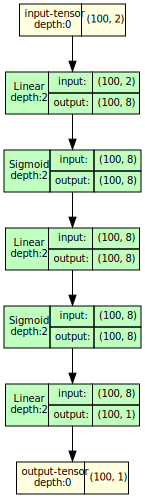

In [13]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f6, input_size=(100, n_features_in), device='cpu', graph_name='MonLoss_graph_f6', graph_dir='figures/', save_graph=True)
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [11]:
# training loop
EPOCHS = 500
BATCH_SIZE = 512

M_operator =  torch.tensor([[1,0], [0,1]], dtype=torch.float32)

losses_f6_total = []
losses_f6 = []
losses_f6_reg = []
s, p = 1, 1/2

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses_total = []
    train_losses = []
    train_losses_reg = []

    permutation = torch.randperm(n_samples_train)

    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f6.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # slice(i, i+BATCH_SIZE) 
        batch_x, batch_y = X_tensor_2d[idx], Z6_tensor[idx]

        # zero grad
        optimizer_f6.zero_grad()

        # forward pass
        output = model_f6(batch_x)

        # compute loss
        loss = criterion_f6(output, batch_y.unsqueeze(1))
        reg_loss = model_f6.monotonicity_loss(batch_x, M_operator)

        loss_total = (1-p) * loss + p * s * reg_loss

        # backward pass
        loss_total.backward()
        train_losses_total.append(loss_total.item())
        train_losses.append(loss.item())
        train_losses_reg.append(reg_loss.item())

        # update weights
        optimizer_f6.step()

    # update s
    reg_loss_magn = np.mean(train_losses_reg)
    loss_magn = np.mean(train_losses)
    r = loss_magn/(reg_loss_magn + 1e-6)
    s = 10**(np.floor(math.log10(r)))

    # update LR
    scheduler_f6.step()

    losses_f6_total.append(np.mean(train_losses_total))
    losses_f6.append(np.mean(train_losses))
    losses_f6_reg.append(np.mean(train_losses_reg))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss total {losses_f6_total[-1]:.7f} - Loss {losses_f6[-1]:.7f} - Reg loss {losses_f6_reg[-1]:.7f} - LR {optimizer_f6.param_groups[0]['lr']:.7f} - s {s:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:13<00:00, 38.08it/s, Loss total 0.0000353 - Loss 0.0000706 - Reg loss 0.0000000 - LR 0.0023730 - s 10.0000000]  


Epoch 500 - train loss: 7.05966362147592e-05
Epoch 500 - train loss total: 3.52983181073796e-05
Epoch 500 - test loss: 6.892925739521161e-05
Epoch 500 - test loss total: 4.200158582534641e-05
Epoch 500 - test reg loss: 0.0


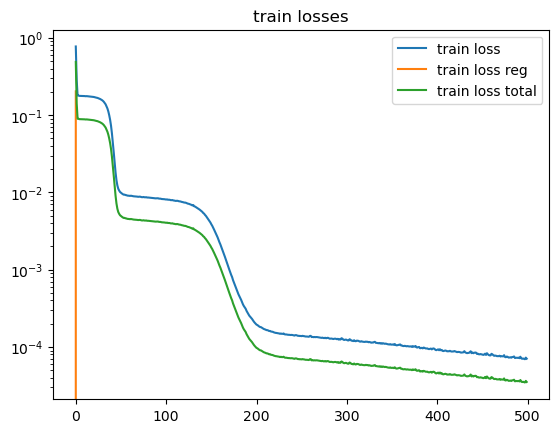

In [14]:
# prediction
with torch.no_grad():
    model_f6.eval()
    y_pred = model_f6(X_tensor_2d)

final_loss = criterion_f6(y_pred, Z6_tensor.unsqueeze(1))
reg_loss = model_f6.monotonicity_loss(X_tensor_2d, torch.eye(2))
loss_total = (1-p) * loss + p * s * reg_loss

print(f"Epoch {EPOCHS} - train loss: {losses_f6[-1]}")
print(f"Epoch {EPOCHS} - train loss total: {losses_f6_total[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")
print(f"Epoch {EPOCHS} - test loss total: {loss_total}")
print(f"Epoch {EPOCHS} - test reg loss: {reg_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f6, label='train loss')
plt.plot(losses_f6_reg, label='train loss reg')
plt.plot(losses_f6_total, label='train loss total')
plt.yscale('log')
plt.title('train losses')
# plt.savefig('figures/train_loss_f6.png')
plt.legend()
plt.show()

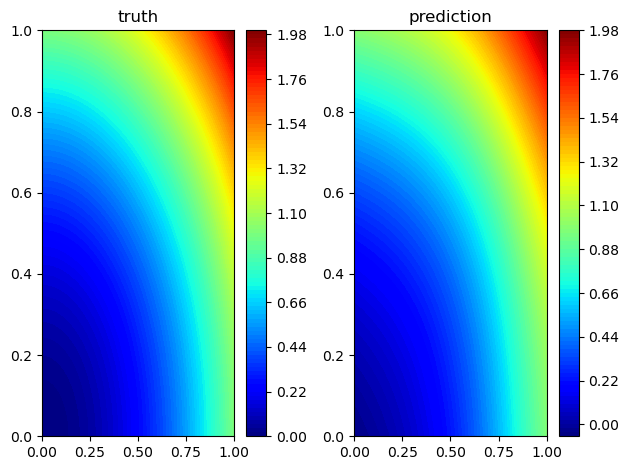

In [15]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, Z6_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

# plt.savefig('figures/truth_prediction_f6.png')
plt.show()

### $f(x, y) = x^3 + 0.5*sin(4*\pi*y)$

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_6709/886178332.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z7_tensor_2D = torch.tensor(f7(X_tensor_f7_2D, Y_tensor_f7_2D))
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_6709/886178332.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z7_tensor = torch.tensor(Z7_tensor_2D.ravel()).float()


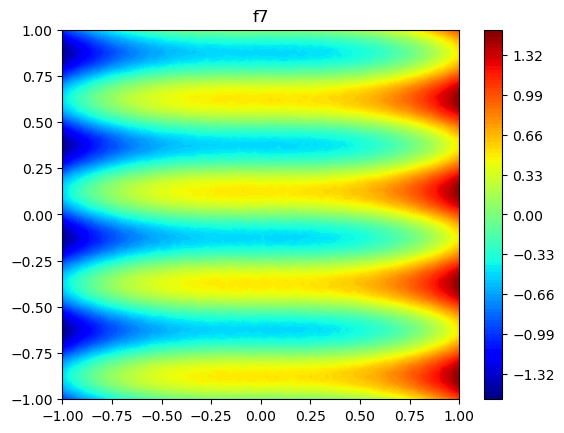

In [48]:
# define space
X_tensor_f7 = torch.linspace(-1, 1, 100)
Y_tensor_f7 = torch.linspace(-1, 1, 100)
X_tensor_f7_2D, Y_tensor_f7_2D = torch.meshgrid(X_tensor_f7, Y_tensor_f7)
Z7_tensor_2D = torch.tensor(f7(X_tensor_f7_2D, Y_tensor_f7_2D))

X_tensor_2d = torch.cat((X_tensor_f7_2D.unsqueeze(2), Y_tensor_f7_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z7_tensor = torch.tensor(Z7_tensor_2D.ravel()).float()

Z7_tensor_min = torch.min(Z7_tensor)
Z7_tensor_max = torch.max(Z7_tensor)
Z7_tensor_normlizer = lambda x: (x - Z7_tensor_min) / (Z7_tensor_max - Z7_tensor_min)
Z7_tensor_denormalizer = lambda x: x * (Z7_tensor_max - Z7_tensor_min) + Z7_tensor_min
Z7_tensor_norm = Z7_tensor_normlizer(Z7_tensor)

# plotting the function
plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f7_2D, Y_tensor_f7_2D, Z7_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f7')
# plt.savefig('figures/f6.png')
plt.show()

In [62]:
# NN parameters
n_features_in = 2
N_HIDDEN = [64, 32, 16, 8, 4, 2]
LR = 1e-2

# defining the model
model_f7 = FCNet(in_features=n_features_in, out_features=1, n_hidden=N_HIDDEN)

# defining the loss function, the optimizer and the scheduler
criterion_f7 = nn.MSELoss()
optimizer_f7 = torch.optim.Adam(model_f7.parameters(), lr=LR)
# scheduler_f7 = torch.optim.lr_scheduler.StepLR(optimizer_f7, step_size=100, gamma=0.75)

n_samples_train = X_tensor_2d.shape[0]

In [63]:
# # Show model
# try:
#     from torchview import draw_graph
#     from IPython.core.display import SVG
# except ImportError as e:
#     print(f"Install graphviz and torchview to show model graph: {e.msg}")
#     graph = None
# else:
#     model_graph = draw_graph(model_f7, input_size=(100, n_features_in), device='cpu', save_graph=True, graph_name='model_f7', graph_dir='figures')
#     graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
# graph

In [64]:
# training loop
EPOCHS = 1_000
BATCH_SIZE = 256
M_operator = torch.tensor([[1,0], [0,0]], dtype=torch.float32)

losses_f7_total = []
losses_f7 = []
losses_f7_reg = []
s, p = 100, 0

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses_total = []
    train_losses = []
    train_losses_reg = []

    # permutation = torch.randperm(n_samples_train)

    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f7.train()

        # choose batch
        idx = slice(i, i+BATCH_SIZE) # permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_2d[idx], Z7_tensor_norm[idx]

        # zero grad
        optimizer_f7.zero_grad()

        # forward pass
        output = model_f7(batch_x)

        # compute loss
        loss = criterion_f7(output, batch_y.unsqueeze(1))
        reg_loss = model_f7.monotonicity_loss(batch_x, M_operator)

        loss_total = (1-p) * loss + p * s * reg_loss

        # backward pass
        loss_total.backward()
        train_losses_total.append(loss_total.item())
        train_losses.append(loss.item())
        train_losses_reg.append(reg_loss.item())

        # update weights
        optimizer_f7.step()

    # update s
    reg_loss_magn = np.mean(train_losses_reg)
    loss_magn = np.mean(train_losses)
    r = loss_magn/(reg_loss_magn + 1e-6)
    s = 10**(np.floor(math.log10(r)))

    # update LR
    # scheduler_f7.step()

    losses_f7_total.append(np.mean(train_losses_total))
    losses_f7.append(np.mean(train_losses))
    losses_f7_reg.append(np.mean(train_losses_reg))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss total {losses_f7_total[-1]:.7f} - Loss {losses_f7[-1]:.7f} - Reg loss {losses_f7_reg[-1]:.7f} - LR {optimizer_f7.param_groups[0]['lr']:.7f} - s {s:.7f}")
    

Epoch 999: 100%|██████████| 1000/1000 [01:25<00:00, 11.65it/s, Loss total 0.0120182 - Loss 0.0120182 - Reg loss 0.9521197 - LR 0.0100000 - s 0.0100000]   


Epoch 1000 - train loss: 0.012018194422125816
Epoch 1000 - train loss total: 0.012018194422125816
Epoch 1000 - train reg loss: 0.9521196531131864
Epoch 1000 - test loss: 0.470599502325058
Epoch 1000 - test loss total: 0.007062864489853382
Epoch 1000 - test reg loss: 24.476240158081055


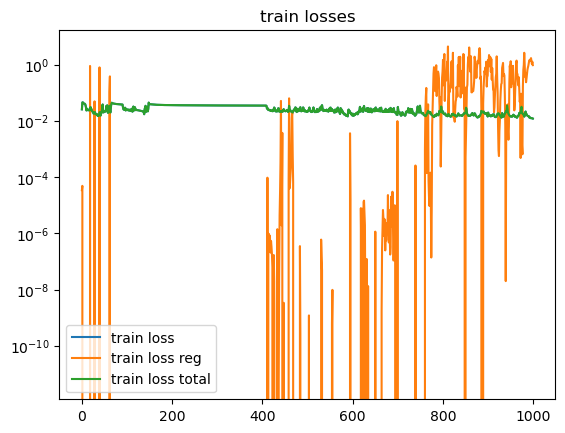

In [65]:
# prediction
with torch.no_grad():
    model_f7.eval()
    y_pred = model_f7(X_tensor_2d)

final_loss = criterion_f7(y_pred, Z7_tensor.unsqueeze(1))
reg_loss = model_f7.monotonicity_loss(X_tensor_2d, M_operator)
loss_total = (1-p) * loss + p * s * reg_loss

print(f"Epoch {EPOCHS} - train loss: {losses_f7[-1]}")
print(f"Epoch {EPOCHS} - train loss total: {losses_f7_total[-1]}")
print(f"Epoch {EPOCHS} - train reg loss: {losses_f7_reg[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")
print(f"Epoch {EPOCHS} - test loss total: {loss_total}")
print(f"Epoch {EPOCHS} - test reg loss: {reg_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f7, label='train loss')
plt.plot(losses_f7_reg, label='train loss reg')
plt.plot(losses_f7_total, label='train loss total')
plt.yscale('log')
plt.title('train losses')
# plt.savefig('figures/train_loss_f6.png')
plt.legend()
plt.show()

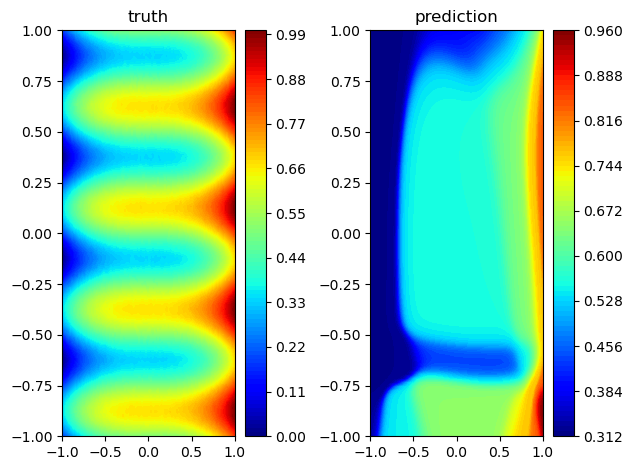

In [66]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f7_2D, Y_tensor_f7_2D, Z7_tensor_norm.view(100, 100), 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f7_2D, Y_tensor_f7_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

# plt.savefig('figures/truth_prediction_f6.png')
plt.show()